<a href="https://colab.research.google.com/github/bhumiii2114/ClusteringAnalysis/blob/main/Clustering_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [30]:
# Load Wine dataset
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
X.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [31]:
# Preprocessing steps
def no_processing(X):
    return X.copy()

def normalize(X):
    return MinMaxScaler().fit_transform(X)

def transform_log(X):
    return FunctionTransformer(np.log1p).fit_transform(X)

def apply_pca(X, n_components=3):
    return PCA(n_components=n_components).fit_transform(X)

# Combined Preprocessing
def transform_normalize(X):
    return normalize(transform_log(X))

def transform_normalize_pca(X):
    return apply_pca(transform_normalize(X))


In [32]:
# Evaluation function
def evaluate_clustering(X, labels):
    try:
        silhouette = silhouette_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)
        return silhouette, ch, db
    except:
        return None, None, None


In [33]:
preprocess_methods = {
    'No Processing': no_processing,
    'Normalization': normalize,
    'Log Transform': transform_log,
    'PCA': lambda X: apply_pca(X),
    'T+N': transform_normalize,
    'T+N+PCA': transform_normalize_pca
}

cluster_range = [3, 4, 5]

# Store results
results = {
    'KMeans': [],
    'Agglomerative': [],
    'MeanShift': []
}

# KMeans & Agglomerative
for name, func in preprocess_methods.items():
    data = func(X)
    for k in cluster_range:
        km = KMeans(n_clusters=k, random_state=0)
        ag = AgglomerativeClustering(n_clusters=k)

        km_labels = km.fit_predict(data)
        ag_labels = ag.fit_predict(data)

        km_scores = evaluate_clustering(data, km_labels)
        ag_scores = evaluate_clustering(data, ag_labels)

        results['KMeans'].append((name, k, *km_scores))
        results['Agglomerative'].append((name, k, *ag_scores))

# MeanShift (no need to vary k)-Because MeanShift is a density-based clustering algorithm that: Automatically estimates the number of clusters based on data distribution.
for name, func in preprocess_methods.items():
    data = func(X)
    try:
        bandwidth = estimate_bandwidth(data, quantile=0.2)
        if bandwidth <= 0:
            raise Exception("Bad bandwidth")
        ms = MeanShift(bandwidth=bandwidth)
        ms_labels = ms.fit_predict(data)
        ms_scores = evaluate_clustering(data, ms_labels)
        n_clusters = len(np.unique(ms_labels))
        results['MeanShift'].append((name, n_clusters, *ms_scores))
    except:
        results['MeanShift'].append((name, n_clusters, None, None, None))


In [34]:
# Convert to DataFrame
def format_results(algo_name):
    df = pd.DataFrame(results[algo_name], columns=['Preprocessing', 'Clusters', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'])
    return df

df_kmeans = format_results('KMeans')
df_agglom = format_results('Agglomerative')
df_meanshift = format_results('MeanShift')

# Display
df_kmeans.head(10)

,Preprocessing,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,No Processing,3,0.571138,561.815658,0.534243
1,No Processing,4,0.545020,599.825000,0.556945
2,No Processing,5,0.547709,726.666943,0.537837
3,Normalization,3,0.301350,83.309389,1.311826
4,Normalization,4,0.233285,63.704640,1.587633
5,Normalization,5,0.206662,53.362697,1.852585
6,Log Transform,3,0.391712,120.005918,1.023407
7,Log Transform,4,0.321844,90.938811,1.324154
8,Log Transform,5,0.283791,81.220963,1.521700
9,PCA,3,0.571655,562.128248,0.533666


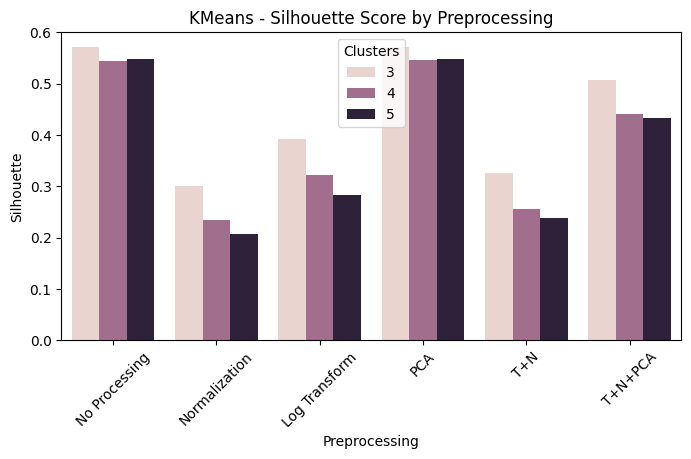

In [35]:
# Plot Silhouette Score for KMeans
plt.figure(figsize=(8,4))
sns.barplot(data=df_kmeans, x='Preprocessing', y='Silhouette', hue='Clusters')
plt.title("KMeans - Silhouette Score by Preprocessing")
plt.xticks(rotation=45)
plt.show()

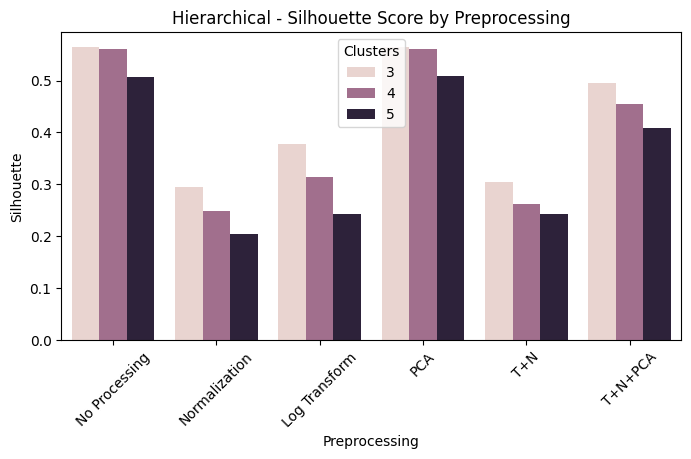

In [36]:
# Plot Silhouette Score for Agglomerative/Hierarchical
plt.figure(figsize=(8,4))
sns.barplot(data=df_agglom, x='Preprocessing', y='Silhouette', hue='Clusters')
plt.title("Hierarchical - Silhouette Score by Preprocessing")
plt.xticks(rotation=45)
plt.show()

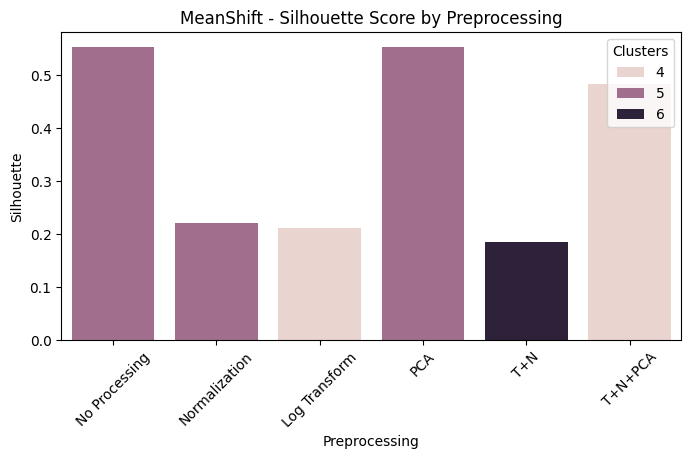

In [37]:
# Plot Silhouette Score for MeanShift
plt.figure(figsize=(8,4))
sns.barplot(data=df_meanshift, x='Preprocessing', y='Silhouette', hue='Clusters')
plt.title("MeanShift - Silhouette Score by Preprocessing")
plt.xticks(rotation=45)
plt.show()

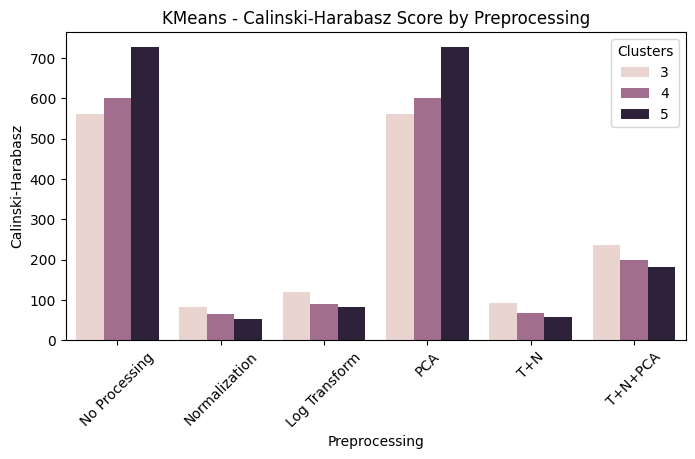

In [38]:
# Plot Silhouette Score for KMeans
plt.figure(figsize=(8,4))
sns.barplot(data=df_kmeans, x='Preprocessing', y='Calinski-Harabasz', hue='Clusters')
plt.title("KMeans - Calinski-Harabasz Score by Preprocessing")
plt.xticks(rotation=45)
plt.show()

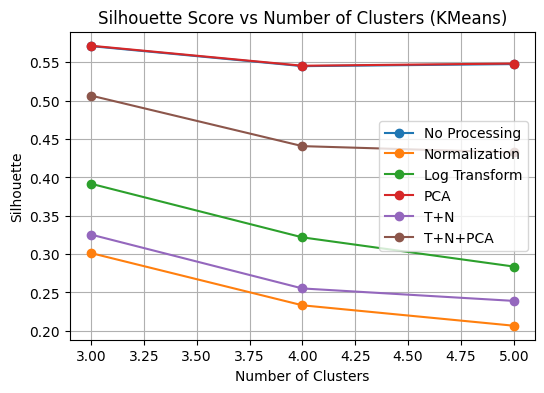

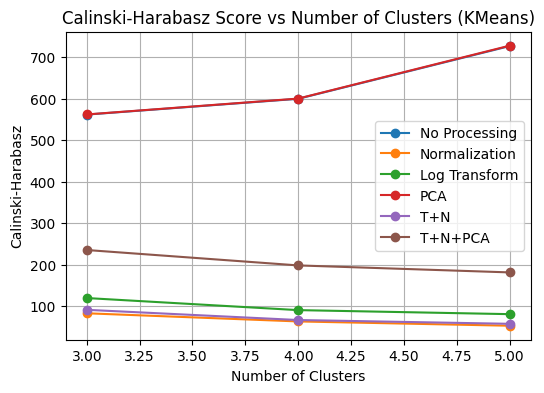

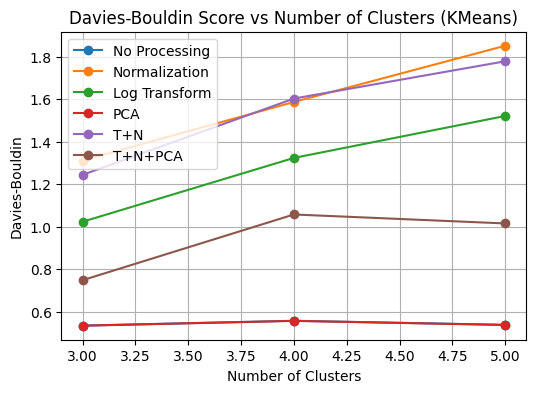

In [39]:
metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Preprocessings available in your results
preprocessings = df_kmeans['Preprocessing'].unique()

# Create separate plots for each metric
for metric, color in zip(metrics, colors):
    plt.figure(figsize=(6, 4))

    for prep in preprocessings:
        sub_df = df_kmeans[df_kmeans['Preprocessing'] == prep]
        plt.plot(sub_df['Clusters'], sub_df[metric], label=prep, marker='o')

    plt.title(f"{metric} Score vs Number of Clusters (KMeans)")
    plt.xlabel("Number of Clusters")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()